In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

%matplotlib inline

from sklearn.cluster import KMeans, MiniBatchKMeans

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/cleveland.csv", header=None, error_bad_lines=False)

In [13]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [4]:
# Define the features and the outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

In [18]:
# Replace missing values (marked by ?) with a 0.
X = X.replace(to_replace='?', value=0)

In [19]:
y.unique()

array([0, 2, 1, 3, 4], dtype=int64)

In [20]:
# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

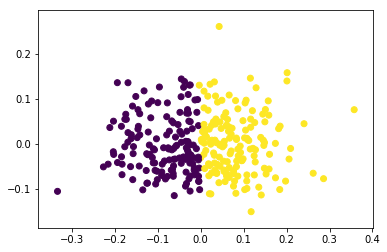

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      84  65
1      55  99
Number of missclassification :  120
Number of correct classification :  183

Difference between correct and incorrect  63
Wall time: 262 ms


In [41]:
%%time
# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)

plt.show()


miss = pd.crosstab(y_pred, y)
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(miss)
print('Number of missclassification : ' ,miss.iloc[0,1] + miss.iloc[1,0])
print('Number of correct classification : ' ,miss.iloc[0,0] + miss.iloc[1,1])

print('\nDifference between correct and incorrect ', 
          np.abs(miss.iloc[:, 0]-miss.iloc[:, 1]).sum())



Try with 3 clusters



In [52]:
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_pca)

miss = pd.crosstab(y_pred, y)
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(miss)

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      65  70
1      25  61
2      49  33




Try minibatchkmeans with 2 clusters

In [31]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

Comparing k-means and mini batch k-means solutions:
col_0    0    1
row_0          
0      149    4
1        0  150




Find the best parameters with Gridsearch

In [54]:

%%time
from sklearn.model_selection import GridSearchCV


# Each batch will be made up of 200 data points.
mbkmeans = MiniBatchKMeans()
hyperparams = {
    'n_clusters': [2, 3, 4,5,6],
    'init':['k-means++'],
    'max_iter':[100,200,300,400,500],
    'tol':[1e-6, 1e-4, 1e-2],
    'batch_size':[100,200, 300]
}

grid_mbkmeans = GridSearchCV(
    estimator=mbkmeans,
    param_grid=hyperparams,
    n_jobs=-1)

grid_mbkmeans.fit(X_pca)

print(grid_mbkmeans.best_params_)


{'batch_size': 200, 'init': 'k-means++', 'max_iter': 200, 'n_clusters': 6, 'tol': 0.01}
Wall time: 4.27 s


In [56]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(**grid_mbkmeans.best_params_)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

In [58]:
df2 = pd.DataFrame(X_pca)
df2[2] = predict_mini


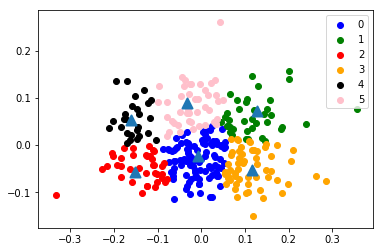

In [63]:
 
# Plot the solution.
plt.scatter(df2[df2[2]==0][0], df2[df2[2]==0][1], c='b', label = 0)
plt.scatter(df2[df2[2]==1][0], df2[df2[2]==1][1], c='g', label = 1)
plt.scatter(df2[df2[2]==2][0], df2[df2[2]==2][1], c='r', label = 2)
plt.scatter(df2[df2[2]==3][0], df2[df2[2]==3][1], c='orange', label = 3)
plt.scatter(df2[df2[2]==4][0], df2[df2[2]==4][1], c='k', label = 4)
plt.scatter(df2[df2[2]==5][0], df2[df2[2]==5][1], c='pink', label = 5)
plt.scatter(minibatchkmeans.cluster_centers_[:, 0], minibatchkmeans.cluster_centers_[:, 1],
marker='^', s=100, linewidth=2)
plt.legend()
plt.show()

I think the best method for this dataset is to use the K-means instead of mini batch because the run-time is negligible here.

The best k value derived by the grid search is 6 here.

Complexity is not an issue with this dataset, at least from a computational power standpoint. 